# Transfer Learning with TensorFlow Hub for TFLite

## Set up library versions for TF2

In [1]:
# !pip uninstall tensorflow --yes
!pip install -U --pre -q tensorflow-gpu==2.0.0-beta1
# !pip install -U --pre -q tf-nightly-gpu-2.0-preview==2.0.0.dev20190715
# Last tested version: 2.0.0-dev20190704

     |████████████████████████████████| 348.9MB 71kB/s 
     |████████████████████████████████| 3.1MB 56.0MB/s 
     |████████████████████████████████| 501kB 50.6MB/s 


In [0]:
# !pip install -U --pre -q tf-estimator-nightly==1.14.0.dev2019071001

In [0]:
# !pip uninstall tensorflow-hub --yes
# !pip install -U --pre -q tf-hub-nightly==0.6.0.dev201907150002
# Last tested version: Hub version:  0.6.0.dev201907160002

Uninstalling tensorflow-hub-0.4.0:
  Successfully uninstalled tensorflow-hub-0.4.0
     |████████████████████████████████| 81kB 3.1MB/s 


In [3]:
from __future__ import absolute_import, division, print_function

import os

import matplotlib.pylab as plt
import numpy as np

import tensorflow as tf
import tensorflow_hub as hub

print("Version: ", tf.__version__)
print("Eager mode: ", tf.executing_eagerly())
print("Hub version: ", hub.__version__)
print("GPU is", "available" if tf.test.is_gpu_available() else "NOT AVAILABLE")

Version:  2.0.0-beta1
Eager mode:  True
Hub version:  0.5.0
GPU is available


## Select the Hub/TF2 module to use

Hub modules for TF 1.x won't work here, please use one of the selections provided.

In [4]:
module_selection = ("mobilenet_v2", 224, 1280) #@param ["(\"mobilenet_v2\", 224, 1280)", "(\"inception_v3\", 299, 2048)"] {type:"raw", allow-input: true}
handle_base, pixels, FV_SIZE = module_selection
MODULE_HANDLE ="https://tfhub.dev/google/tf2-preview/{}/feature_vector/4".format(handle_base)
IMAGE_SIZE = (pixels, pixels)
print("Using {} with input size {} and output dimension {}".format(
  MODULE_HANDLE, IMAGE_SIZE, FV_SIZE))

Using https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4 with input size (224, 224) and output dimension 1280


## Data preprocessing

Use [TensorFlow Datasets](http://tensorflow.org/datasets) to load the cats and dogs dataset.

This `tfds` package is the easiest way to load pre-defined data. If you have your own data, and are interested in importing using it with TensorFlow see [loading image data](../load_data/images.ipynb)


In [0]:
import tensorflow_datasets as tfds
tfds.disable_progress_bar()

The `tfds.load` method downloads and caches the data, and returns a `tf.data.Dataset` object. These objects provide powerful, efficient methods for manipulating data and piping it into your model.

Since `"cats_vs_dog"` doesn't define standard splits, use the subsplit feature to divide it into (train, validation, test) with 80%, 10%, 10% of the data respectively.

In [6]:
splits = tfds.Split.ALL.subsplit(weighted=(80, 10, 10))

splits, info = tfds.load('cats_vs_dogs', with_info=True, as_supervised=True, split = splits)

(train_examples, validation_examples, test_examples) = splits

num_examples = info.splits['train'].num_examples
num_classes = info.features['label'].num_classes

/usr/local/lib/python3.6/dist-packages/urllib3/connectionpool.py:847: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)
W0803 04:41:17.875909 140336087701376 cats_vs_dogs.py:117] 1738 images were corrupted and were skipped
W0803 04:41:17.886837 140336087701376 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow_datasets/core/file_format_adapter.py:209: tf_record_iterator (from tensorflow.python.lib.io.tf_record) is deprecated and will be removed in a future version.
Instructions for updating:
Use eager execution and: 
`tf.data.TFRecordDataset(path)`


Dataset cats_vs_dogs downloaded and prepared to /root/tensorflow_datasets/cats_vs_dogs/2.0.1. Subsequent calls will reuse this data.


### Format the Data

Use the `tf.image` module to format the images for the task.

Resize the images to a fixes input size, and rescale the input channels

In [0]:
def format_image(image, label):
  image = tf.image.resize(image, IMAGE_SIZE) / 255.0
  return  image, label

Now shuffle and batch the data


In [0]:
BATCH_SIZE = 32 #@param {type:"integer"}

In [0]:
train_batches = train_examples.shuffle(num_examples // 4).map(format_image).batch(BATCH_SIZE).prefetch(1)
validation_batches = validation_examples.map(format_image).batch(BATCH_SIZE).prefetch(1)
test_batches = test_examples.map(format_image).batch(1)

Inspect a batch

In [10]:
for image_batch, label_batch in train_batches.take(1):
  pass

image_batch.shape

TensorShape([32, 224, 224, 3])


## Defining the model

All it takes is to put a linear classifier on top of the `feature_extractor_layer` with the Hub module.

For speed, we start out with a non-trainable `feature_extractor_layer`, but you can also enable fine-tuning for greater accuracy.

In [0]:
do_fine_tuning = False #@param {type:"boolean"}

Load TFHub Module

In [0]:
feature_extractor = hub.KerasLayer(MODULE_HANDLE,
                                   input_shape=IMAGE_SIZE + (3,), 
                                   output_shape=[FV_SIZE],
                                   trainable=do_fine_tuning)

In [13]:
print("Building model with", MODULE_HANDLE)
model = tf.keras.Sequential([
    feature_extractor,
    tf.keras.layers.Dense(num_classes, activation='softmax')
])
model.summary()

Building model with https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer (KerasLayer)     (None, 1280)              2257984   
_________________________________________________________________
dense (Dense)                (None, 2)                 2562      
Total params: 2,260,546
Trainable params: 2,562
Non-trainable params: 2,257,984
_________________________________________________________________


In [0]:
#@title (Optional) Unfreeze some layers
NUM_LAYERS = 10 #@param {type:"slider", min:1, max:50, step:1}
      
if do_fine_tuning:
  feature_extractor.trainable = True
  
  for layer in model.layers[-NUM_LAYERS:]:
    layer.trainable = True

else:
  feature_extractor.trainable = False

## Training the model

In [0]:
if do_fine_tuning:
  model.compile(
    optimizer=tf.keras.optimizers.SGD(lr=0.002, momentum=0.9), 
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics=['accuracy'])
else:
  model.compile(
    optimizer='adam', 
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy'])

In [16]:
EPOCHS = 5
hist = model.fit(train_batches,
                    epochs=EPOCHS,
                    validation_data=validation_batches)

Epoch 1/5


W0803 04:42:08.886037 140336087701376 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


582/582 [==============================] - 49s 84ms/step - loss: 0.0554 - accuracy: 0.9806 - val_loss: 0.0000e+00 - val_accuracy: 0.0000e+00
Epoch 2/5
582/582 [==============================] - 43s 73ms/step - loss: 0.0290 - accuracy: 0.9906 - val_loss: 0.0364 - val_accuracy: 0.9879
Epoch 3/5
582/582 [==============================] - 43s 73ms/step - loss: 0.0241 - accuracy: 0.9928 - val_loss: 0.0361 - val_accuracy: 0.9871
Epoch 4/5
582/582 [==============================] - 42s 73ms/step - loss: 0.0209 - accuracy: 0.9940 - val_loss: 0.0365 - val_accuracy: 0.9858
Epoch 5/5
582/582 [==============================] - 42s 73ms/step - loss: 0.0185 - accuracy: 0.9950 - val_loss: 0.0373 - val_accuracy: 0.9862


## Export the model

In [0]:
CATS_VS_DOGS_SAVED_MODEL = "exp_saved_model"

Export the SavedModel

In [0]:
tf.saved_model.save(model, CATS_VS_DOGS_SAVED_MODEL)

In [19]:
%%bash -s $CATS_VS_DOGS_SAVED_MODEL
saved_model_cli show --dir $1 --tag_set serve --signature_def serving_default

The given SavedModel SignatureDef contains the following input(s):
  inputs['keras_layer_input'] tensor_info:
      dtype: DT_FLOAT
      shape: (-1, 224, 224, 3)
      name: serving_default_keras_layer_input:0
The given SavedModel SignatureDef contains the following output(s):
  outputs['dense'] tensor_info:
      dtype: DT_FLOAT
      shape: (-1, 2)
      name: StatefulPartitionedCall:0
Method name is: tensorflow/serving/predict


In [0]:
loaded = tf.saved_model.load(CATS_VS_DOGS_SAVED_MODEL)

In [21]:
print(list(loaded.signatures.keys()))
infer = loaded.signatures["serving_default"]
print(infer.structured_input_signature)
print(infer.structured_outputs)

['serving_default']
((), {'keras_layer_input': TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name='keras_layer_input')})
{'dense': TensorSpec(shape=(None, 2), dtype=tf.float32, name='dense')}


## Convert using TFLite's Converter

Load the TFLiteConverter with the SavedModel

In [0]:
converter = tf.lite.TFLiteConverter.from_saved_model(CATS_VS_DOGS_SAVED_MODEL)

### Post-training quantization
The simplest form of post-training quantization quantizes weights from floating point to 8-bits of precision. This technique is enabled as an option in the TensorFlow Lite converter. At inference, weights are converted from 8-bits of precision to floating point and computed using floating-point kernels. This conversion is done once and cached to reduce latency.

To further improve latency, hybrid operators dynamically quantize activations to 8-bits and perform computations with 8-bit weights and activations. This optimization provides latencies close to fully fixed-point inference. However, the outputs are still stored using floating point, so that the speedup with hybrid ops is less than a full fixed-point computation.

In [0]:
converter.optimizations = [tf.lite.Optimize.DEFAULT]

### Post-training integer quantization
We can get further latency improvements, reductions in peak memory usage, and access to integer only hardware accelerators by making sure all model math is quantized. To do this, we need to measure the dynamic range of activations and inputs with a representative data set. You can simply create an input data generator and provide it to our converter.

In [0]:
def representative_data_gen():
  for input_value, _ in test_batches.take(100):
    yield [input_value]

In [0]:
converter.representative_dataset = representative_data_gen

The resulting model will be fully quantized but still take float input and output for convenience.

Ops that do not have quantized implementations will automatically be left in floating point. This allows conversion to occur smoothly but may restrict deployment to accelerators that support float. 

### Full integer quantization

To require the converter to only output integer operations, one can specify:

In [0]:
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]

### Finally convert the model

In [0]:
tflite_model = converter.convert()
tflite_model_file = 'converted_model.tflite'

with open(tflite_model_file, "wb") as f:
  f.write(tflite_model)

##Test the TFLite model using the Python Interpreter

In [0]:
# Load TFLite model and allocate tensors.
  
interpreter = tf.lite.Interpreter(model_path=tflite_model_file)
interpreter.allocate_tensors()

input_index = interpreter.get_input_details()[0]["index"]
output_index = interpreter.get_output_details()[0]["index"]

In [0]:
from tqdm import tqdm

# Gather results for the randomly sampled test images
predictions = []

test_labels, test_imgs = [], []
for img, label in tqdm(test_batches.take(10)):
  interpreter.set_tensor(input_index, img)
  interpreter.invoke()
  predictions.append(interpreter.get_tensor(output_index))
  
  test_labels.append(label.numpy()[0])
  test_imgs.append(img)

10it [00:01,  8.49it/s]


In [0]:
#@title Utility functions for plotting
# Utilities for plotting

class_names = ['cat', 'dog']

def plot_image(i, predictions_array, true_label, img):
  predictions_array, true_label, img = predictions_array[i], true_label[i], img[i]
  plt.grid(False)
  plt.xticks([])
  plt.yticks([])
    
  img = np.squeeze(img)

  plt.imshow(img, cmap=plt.cm.binary)

  predicted_label = np.argmax(predictions_array)
  if predicted_label == true_label:
    color = 'green'
  else:
    color = 'red'
  
  plt.xlabel("{} {:2.0f}% ({})".format(class_names[predicted_label],
                                100*np.max(predictions_array),
                                class_names[true_label]),
                                color=color)



NOTE: Colab runs on server CPUs. At the time of writing this, TensorFlow Lite doesn't have super optimized server CPU kernels. For this reason post-training full-integer quantized models  may be slower here than the other kinds of optimized models. But for mobile CPUs, considerable speedup can be observed.

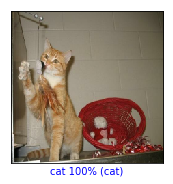

In [0]:
#@title Visualize the outputs { run: "auto" }
index = 2 #@param {type:"slider", min:0, max:9, step:1}
plt.figure(figsize=(6,3))
plt.subplot(1,2,1)
plot_image(index, predictions, test_labels, test_imgs)
plt.show()

Download the model

In [0]:
from google.colab import files

files.download('converted_model.tflite')

labels = ['cat', 'dog']

with open('labels.txt', 'w') as f:
  f.write('\n'.join(labels))
  
files.download('labels.txt')

# Prepare the test images for download (Optional)

This part involves downloading additional test images for the Mobile Apps only in case you need to try out more samples

In [0]:
!mkdir -p test_images

In [0]:
from PIL import Image

for index, (image, label) in enumerate(test_batches.take(50)):
  image = tf.cast(image * 255.0, tf.uint8)
  image = tf.squeeze(image).numpy()
  pil_image = Image.fromarray(image)
  pil_image.save('test_images/{}_{}.jpg'.format(class_names[label[0]], index))

In [0]:
!ls test_images

0.jpg	15.jpg	20.jpg	26.jpg	31.jpg	37.jpg	42.jpg	48.jpg	8.jpg
10.jpg	16.jpg	21.jpg	27.jpg	32.jpg	38.jpg	43.jpg	49.jpg	9.jpg
11.jpg	17.jpg	22.jpg	28.jpg	33.jpg	39.jpg	44.jpg	4.jpg	{}.jpg
12.jpg	18.jpg	23.jpg	29.jpg	34.jpg	3.jpg	45.jpg	5.jpg
13.jpg	19.jpg	24.jpg	2.jpg	35.jpg	40.jpg	46.jpg	6.jpg
14.jpg	1.jpg	25.jpg	30.jpg	36.jpg	41.jpg	47.jpg	7.jpg


In [0]:
!zip -qq cats_vs_dogs_test_images.zip -r test_images/

In [0]:
files.download('cats_vs_dogs_test_images.zip')